In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt

In [2]:
class data_manager():

  def __init__(self, data='cars196', vgg_preprocess=True):

    self.dataset, self.dataset_info = tfds.load(data, with_info=True, as_supervised=True)
    self.vgg_preprocess = vgg_preprocess

  def preprocess_fn(self, image, label):
    
    image = tf.image.resize(image, (224, 224))
    if self.vgg_preprocess:
      image = tf.keras.applications.vgg16.preprocess_input(image)
    label = tf.one_hot(tf.cast(label, tf.int32), depth=self.dataset_info.features["label"].num_classes)
    return image, label


  def load_data(self, batch_size=1, split=True):

    if split:
      train_dataset, test_dataset = self.dataset['train'], self.dataset['test']
      train_dataset = train_dataset.map(self.preprocess_fn, num_parallel_calls=tf.data.AUTOTUNE)
      test_dataset = test_dataset.map(self.preprocess_fn, num_parallel_calls=tf.data.AUTOTUNE)
      return train_dataset.batch(batch_size), test_dataset.batch(batch_size), self.dataset_info
    else:
      self.train_dataset = self.dataset['train']
      train_dataset = self.train_dataset.map(self.preprocess_fn, num_parallel_calls=tf.data.AUTOTUNE)
      return train_dataset.batch(batch_size), self.dataset_info

# data = data_manager(data='cars196', vgg_preprocess=True)
# train_dataset, test_dataset, dataset_info = data.load_data(batch_size=32, split=True)

In [3]:
class VGG16():
  def __init__(self,dataset_info, weights='imagenet', include_top=False, input_shape=(224,224,3)):
    self.dataset_info = dataset_info
    self.weights = weights
    self.include_top = include_top
    self.input_shape = input_shape

  def build_embedding(self, all_par=True):
    if all_par:
      emb_input = tf.keras.layers.Input(shape=self.input_shape)
      vgg16 = tf.keras.applications.VGG16(weights=self.weights, include_top=self.include_top, input_shape=self.input_shape)(emb_input)
      x = tf.keras.layers.GlobalAveragePooling2D()(vgg16)
      emb = tf.keras.layers.Dense(512, activation='relu')(x)

      embedding = tf.keras.Model(inputs=[emb_input], outputs=[emb])

    else:
      emb_input = tf.keras.layers.Input(shape=self.input_shape)
      vgg16 = tf.keras.applications.VGG16(weights=self.weights, include_top=self.include_top, input_shape=self.input_shape)
      for layer in vgg16.layers:
        layer.trainable = False
      vgg16 = vgg16(emb_input)
      x = tf.keras.layers.GlobalAveragePooling2D()(vgg16)
      emb = tf.keras.layers.Dense(512, activation='relu')(x)

      embedding = tf.keras.Model(inputs=[emb_input], outputs=[emb])

    return embedding


  def train(self, train_dataset, epochs, all_par):

    embedding = self.build_embedding(all_par=all_par)

    input = tf.keras.layers.Input(shape=self.input_shape)
    emb = embedding(input)
    output = tf.keras.layers.Dense(self.dataset_info.features["label"].num_classes, activation="softmax")(emb)
    model = tf.keras.Model(inputs=[input], outputs=[output])
    
    
    best_model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
        filepath='/content/drive/MyDrive/img_ret/best_model_online.h5',
        save_best_only=True,
        save_weights_only=False,
        monitor='accuracy',
        mode='max',
        verbose=1)

    last_model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
        filepath='/content/drive/MyDrive/img_ret/last_model_omline.h5',
        save_best_only=False,
        save_weights_only=False,
        monitor='accuracy',
        mode='max',
        verbose=1)
    
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.AUC()])
    history = model.fit(train_dataset, epochs=epochs, batch_size=32, callbacks=[best_model_checkpoint, last_model_checkpoint])

    return model, embedding, history

  def image_embedding(self, embedding, train_dataset, test_dataset):
    
    train_emb = embedding.predict(train_dataset)
    test_emb = embedding.predict(test_dataset)

    return train_emb, test_emb

# vgg = VGG16(dataset_info)
# model, embedding, history = vgg.train(train_dataset, epochs=1, all_par=False)
# train_dataset, test_dataset, dataset_info = data.load_data(batch_size=1, split=True)
# image_embedding(self, embedding, train_dataset, test_dataset)

In [10]:
class inference():

  def __init__(self, data='cars196', vgg_preprocess=False):

    data = data_manager(data=data, vgg_preprocess=vgg_preprocess)
    self.train_dataset, self.test_dataset, self.dataset_info = data.load_data(batch_size=1, split=True)

  def nearest_neighbors(self, train_emb, test_emb, test_idx, n_neighbors=5):

    knn = NearestNeighbors(metric="euclidean")
    knn.fit(train_emb)
    (neighbors_dist,),(neighbors_idx,) = knn.kneighbors(np.reshape(test_emb[test_idx], (1,-1)), n_neighbors=n_neighbors)

    return neighbors_dist, neighbors_idx


  def retrieve_image(self, train_emb, test_emb, test_idx, n_neighbors=5):

    _, neighbors_idx = self.nearest_neighbors(train_emb, test_emb, test_idx, n_neighbors=5)

    for k, test_example in enumerate(self.test_dataset):
      if k == test_idx:
        image, label = test_example
        plt.figure(figsize=[16,14])
        plt.subplot(n_neighbors+1,1,1)
        plt.imshow(np.clip(image[0], 0,255) / 255)
        plt.axis('off')
        plt.title("Original{}:{}".format(np.where(label[0]==1)[0], self.dataset_info.features['label'].names[np.where(label[0]==1)[0][0]]))

        break
    for j in range(len(neighbors_idx)):
      for i, example in enumerate(self.train_dataset):
        if i == neighbors_idx[j]:
          image, label = example
          plt.subplot(n_neighbors+1,1,j+2)
          plt.imshow(np.clip(image[0], 0,255) / 255)
          plt.axis('off')
          plt.title("Recommend{}:{}".format(np.where(label[0]==1)[0], self.dataset_info.features['label'].names[np.where(label[0]==1)[0][0]]))
          break


  def precision_recall(self, train_emb, test_emb, n_neighbors=5):
    tp = 0
    for test_idx, test_example in enumerate(self.test_dataset):
      _, neighbors_idx = self.nearest_neighbors(train_emb, test_emb, test_idx, n_neighbors=5)
      _, test_label = test_example
      test_label = np.where(test_label[0]==1)[0][0]
      for j in range(len(neighbors_idx)):
        for i, example in enumerate(self.train_dataset):
          if i == neighbors_idx[j]:
            _, label = example
            label = np.where(label[0]==1)[0][0]
            if test_label == label:
              tp += 1
            break
    return tp/(n_neighbors*(test_idx+1)), tp/(test_idx+1)
# visualize = image_retreival()
# train_emb, test_emb = viaulaize.image_embedding(embedding)
# visualize.retrieve_image(self, train_emb, test_emb, test_idx, n_neighbors=5)

In [7]:
data = data_manager(data='cars196', vgg_preprocess=True)
train_dataset, test_dataset, dataset_info = data.load_data(batch_size=32, split=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/8144 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cars196/2.1.0.incompleteA876NP/cars196-train.tfrecord*...:   0%|          …

Generating test examples...:   0%|          | 0/8041 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cars196/2.1.0.incompleteA876NP/cars196-test.tfrecord*...:   0%|          |…

Dataset cars196 downloaded and prepared to /root/tensorflow_datasets/cars196/2.1.0. Subsequent calls will reuse this data.


In [8]:
vgg = VGG16(dataset_info, weights='imagenet', include_top=False, input_shape=(224,224,3))
model, embedding, history = vgg.train(train_dataset, epochs=20, all_par=False)

58889256/58889256 [==============================] - 0s 0us/step
Epoch 1/20
255/255 [==============================] - ETA: 0s - loss: 5.0649 - accuracy: 0.0636 - precision: 0.2449 - recall: 0.0074 - auc: 0.7101
Epoch 1: accuracy improved from -inf to 0.06361, saving model to /content/drive/MyDrive/img_ret/best_model_online.h5

Epoch 1: saving model to /content/drive/MyDrive/img_ret/last_model_omline.h5
255/255 [==============================] - 60s 184ms/step - loss: 5.0649 - accuracy: 0.0636 - precision: 0.2449 - recall: 0.0074 - auc: 0.7101
Epoch 2/20
255/255 [==============================] - ETA: 0s - loss: 2.9868 - accuracy: 0.2798 - precision: 0.7150 - recall: 0.1029 - auc: 0.9223
Epoch 2: accuracy improved from 0.06361 to 0.27984, saving model to /content/drive/MyDrive/img_ret/best_model_online.h5

Epoch 2: saving model to /content/drive/MyDrive/img_ret/last_model_omline.h5
255/255 [==============================] - 56s 220ms/step - loss: 2.9868 - accuracy: 0.2798 - precision: 

In [11]:
train_dataset, test_dataset, dataset_info = data.load_data(batch_size=1, split=True)
train_emb, test_emb = vgg.image_embedding(embedding, train_dataset, test_dataset)

8041/8041 [==============================] - 70s 9ms/step


In [12]:
inf = inference(data='cars196', vgg_preprocess=False)

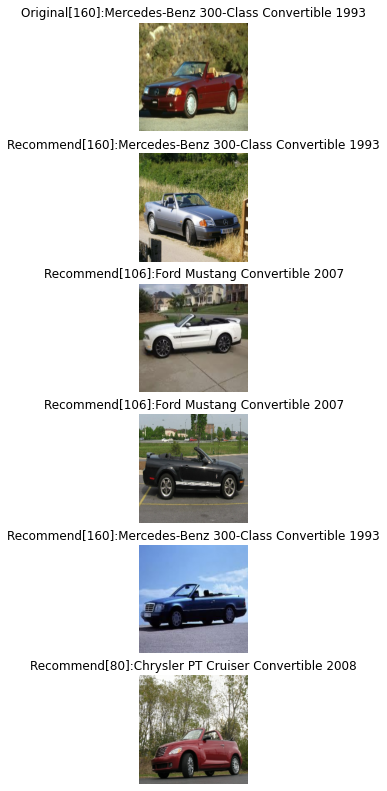

In [13]:
inf.retrieve_image(train_emb, test_emb, test_idx=55, n_neighbors=5)

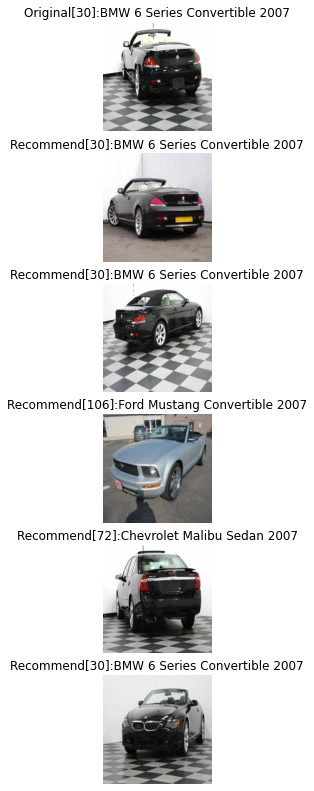

In [14]:
inf.retrieve_image(train_emb, test_emb, test_idx=250, n_neighbors=5)

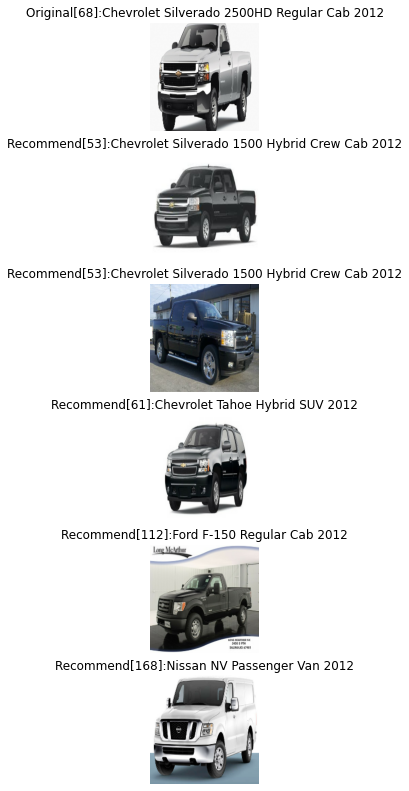

In [15]:
inf.retrieve_image(train_emb, test_emb, test_idx=7500, n_neighbors=5)

In [1]:
precision, recall = inf.precision_recall(train_emb, test_emb, n_neighbors=5)

NameError: ignored

In [ ]:
print("Precision : {}".format(precision))
print("Recall : {}".format(recall))

In [ ]:
inf.retrieve_image(train_emb, test_emb, test_idx=0, n_neighbors=5)

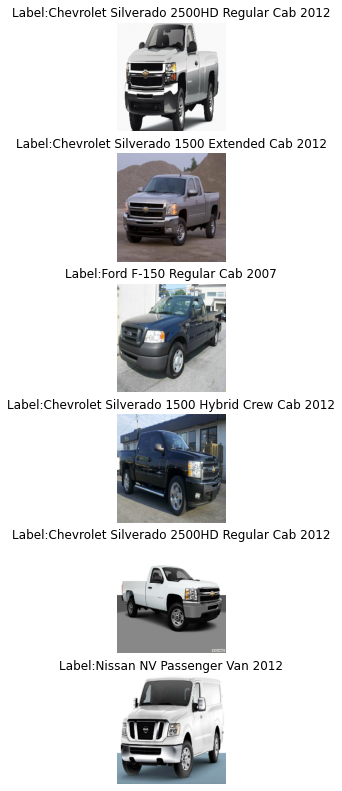

In [33]:
visualize.retrieve_image(train_emb, test_emb, test_idx=7500, n_neighbors=5)

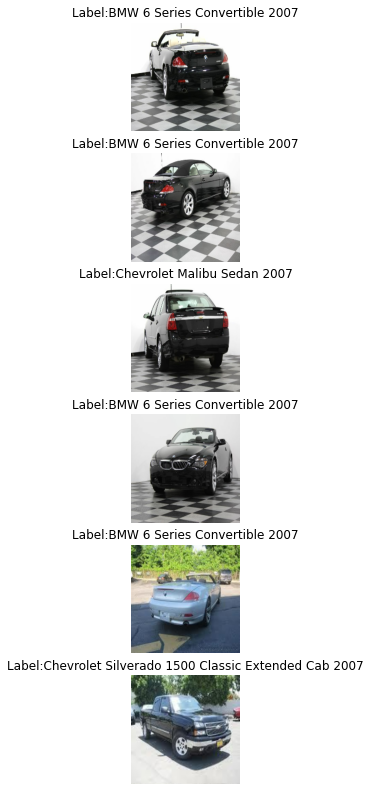

In [32]:
visualize.retrieve_image(train_emb, test_emb, test_idx=250, n_neighbors=5)

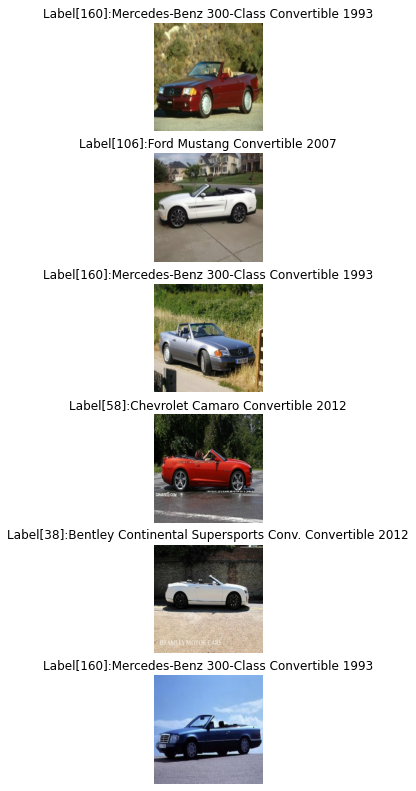

In [51]:
visualize.retrieve_image(train_emb, test_emb, test_idx=55, n_neighbors=5)

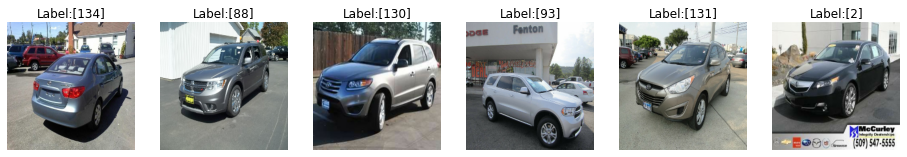

In [23]:
visualize.retrieve_image(train_emb, test_emb, test_idx=100, n_neighbors=5)

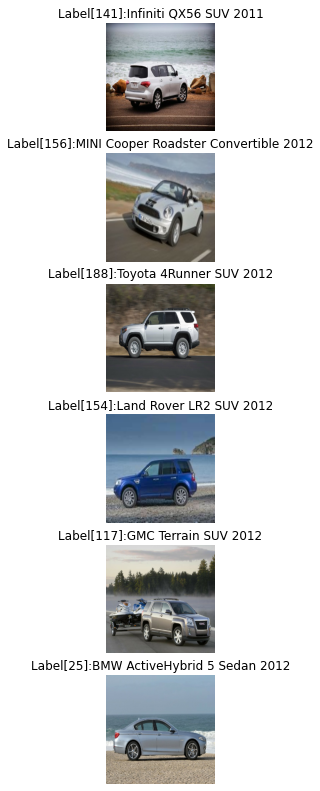

In [50]:
visualize.retrieve_image(train_emb, test_emb, test_idx=0, n_neighbors=5)

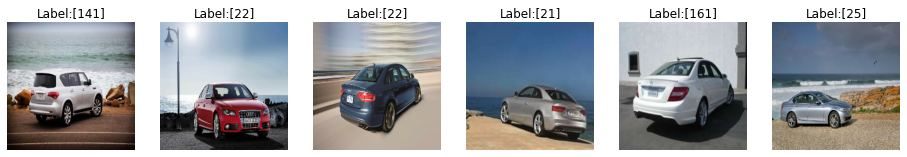

In [10]:
# visualize = image_retreival(data='cars196', vgg_preprocess=False)
# visualize.retrieve_image(train_emb, test_emb, test_idx=0, n_neighbors=5)

In [ ]:
### STanford Online #####

In [ ]:
data = data_manager(data='cars196', vgg_preprocess=True)
train_dataset, test_dataset, dataset_info = data.load_data(batch_size=1, split=True)

In [ ]:
train_emb = embedding.predict(train_dataset)

8144/8144 [==============================] - 4448s 546ms/step


In [ ]:
nei_clf = NearestNeighbors(metric="euclidean")
nei_clf.fit(train_emb)

NearestNeighbors(metric='euclidean')

In [ ]:
code = embedding.predict(test_dataset)

8041/8041 [==============================] - 4406s 548ms/step


In [ ]:
(distances,),(idx,) = nei_clf.kneighbors(np.reshape(code[55], (1,-1)),n_neighbors=5)
idx

array([ 566, 2712, 5561, 3174, 6481])

In [ ]:
distances

array([13.629548 , 13.65268  , 14.5764475, 14.644935 , 14.893073 ],
      dtype=float32)

In [ ]:
import matplotlib.pyplot as plt
for k, test_example in enumerate(test_dataset):
  if k == 55:
    image, label = test_example
    plt.figure(figsize=[16,14])
    plt.subplot(1,6,1)
    plt.imshow(np.clip(image[0], 0,255) / 255)
    plt.axis('off')
    plt.title("Label:{}".format(np.where(label[0]==1)[0]))

    break
for j in range(len(idx)):
  for i, example in enumerate(train_dataset):
    if i == idx[j]:
      image, label = example
      plt.subplot(1,6,j+2)
      plt.imshow(np.clip(image[0], 0,255) / 255)
      plt.axis('off')
      plt.title("Label:{}".format(np.where(label[0]==1)[0]))
      break

NameError: ignored

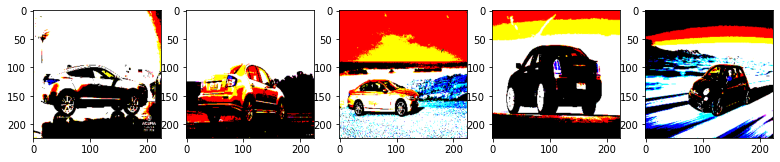

In [ ]:
import matplotlib.pyplot as plt
for k, test_example in enumerate(test_dataset):
  if k == 0:
    image, label = test_example
    
    plt.figure(figsize=[16,14])
    plt.subplot(1,4,1)
    plt.imshow(np.clip(image[0]+0.5, 0,1))
    break
for j in range(len(idx)):
  for i, example in enumerate(train_dataset):
    if i == idx[j]:
      image, label = example
      plt.subplot(1,6,j+1)
      plt.imshow(np.clip(image[0]+0.5, 0,1))
      break

In [ ]:
label

<tf.Tensor: shape=(1, 196), dtype=float32, numpy=
array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.]], dtype=float32)>

In [ ]:
dataset_info.features


FeaturesDict({
    'bbox': BBoxFeature(shape=(4,), dtype=float32),
    'id': Text(shape=(), dtype=string),
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=196),
})

In [ ]:
test_loss, test_accuracy, test_precision, test_recall, test_mAP = model.evaluate(test_dataset, verbose=0)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_accuracy)
print('Test Precision:', test_precision)
print('Test Recall:', test_recall)
print('Test Mean Average Precision:', test_mAP)

ValueError: ignored

In [ ]:
# class data_manager():

#   def __init__(self, data='cars196'):

#     self.dataset, self.dataset_info = tfds.load(data, with_info=True, as_supervised=True)

#   def preprocess_fn(self, image, label):
    
#     image = tf.image.resize(image, (224, 224))
#     image = tf.keras.applications.vgg16.preprocess_input(image)
#     label = tf.one_hot(tf.cast(label, tf.int32), depth=196)
#     return image, label

#   def tensor(self, dataset, batch_size=1):
#         images = tf.TensorArray(tf.float32, size=0, dynamic_size=True)
#         labels = tf.TensorArray(tf.float32, size=0, dynamic_size=True)
        
#         for i, element in enumerate(dataset):
#             image, label = element
#             images = images.write(i, image)
#             labels = labels.write(i, label)
            
#             if (i + 1) % batch_size == 0:
#                 images = images.stack()
#                 labels = labels.stack()
#                 yield images, labels
#                 images = tf.TensorArray(tf.float32, size=0, dynamic_size=True)
#                 labels = tf.TensorArray(tf.float32, size=0, dynamic_size=True)
        
#         if (i + 1) % batch_size != 0:
#             images = images.stack()
#             labels = labels.stack()
#         return images, labels


#   def load_data(self, batch_size=1, split=True):

#     if split:
#       train_dataset, test_dataset = self.dataset['train'], self.dataset['test']
#       train_dataset = train_dataset.map(self.preprocess_fn, num_parallel_calls=tf.data.AUTOTUNE)
#       test_dataset = test_dataset.map(self.preprocess_fn, num_parallel_calls=tf.data.AUTOTUNE)
#       return self.tensor(train_dataset.batch(1)), self.tensor(test_dataset.batch(1)), self.dataset_info
#     else:
#       self.train_dataset = self.dataset['train']
#       train_dataset = self.train_dataset.map(self.preprocess_fn, num_parallel_calls=tf.data.AUTOTUNE)
#       return self.tensor(train_dataset.batch(batch_size)), self.dataset_info

# data = data_manager(data='cars196')
# train_dataset, test_dataset, dataset_info = data.load_data(batch_size=32, split=True)


# ####################################################################3
# ##########################################################